In [1]:
import pandas as pd
import numpy as np
import math
import tabula


import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_info_from_text(text):
    
    if text.startswith('Mud System:'):
        return text[12:]
    if text.startswith('Density'):
        return text[8: ]
    if text.startswith('Vis (Drilling)'):
        return text[15:]
    if text.startswith('Vis (Case)'):
        return text[11:]
    if text.startswith('PV'):
        return text[3:]
    if text.startswith('YP'):
        return text[3:]
    if text.startswith('Gels'):
        return text[5:]
    if text.startswith('Density'):
        return text[8:]
    if text.startswith('Vis'):
        return text[4:] 
    if text.startswith('Calcium'):
        return text[8:] 
    if text.startswith('Inhibition'):
        return text[11:] 
    if text.startswith('Sweeps'):
        return text[7:]
    if text.startswith('Fluid Loss'):
        return text[10:]    
    if text.startswith('pH'):
        return text[3:]       
    return np.nan

In [3]:
def get_initial_from_text(text):
    
    if text.startswith('Mud System:'):
        return 'Mud System:'
    if text.startswith('Density'):
        return 'Density'
    if text.startswith('Vis (Drilling)'):
        return 'Vis (Drilling)'
    if text.startswith('Vis (Case)'):
        return 'Vis (Case)'
    if text.startswith('PV'):
        return 'PV'
    if text.startswith('YP'):
        return 'YP'
    if text.startswith('Gels'):
        return 'Gels'
    if text.startswith('Density'):
        return 'Density'
    if text.startswith('Vis'):
        return 'Vis' 
    if text.startswith('Calcium'):
        return 'Calcium' 
    if text.startswith('Inhibition'):
        return 'Inhibition' 
    if text.startswith('Sweeps'):
        return 'Sweeps'
    if text.startswith('Fluid Loss'):
        return 'Fluid Loss'    
    if text.startswith('pH'):
        return 'pH'      
    return text

In [123]:
def get_table1_limits(table):
    key_wrd = 'Total Depth HZ'
    first_col = 'Unnamed: 0'
    table_ending = np.where( table[first_col]  == key_wrd)[0][0] + 1
    cols = table.columns[:4]
    
    return table[:table_ending][cols]

def fixing_table1_colnames(table):
    result = table.copy()

    for col in result.columns:
        col_name = col + result[col].fillna('').iloc[0] + result[col].fillna('').iloc[1]
        col_name = col_name.replace('Unnamed: 0', '')
        result.rename(columns = {col: col_name}, inplace = True)
    return result[3:].dropna(axis=0, how='all')

def fixing_table1_fnames(table):
    result = table.copy()
    for i in range(len(result)):
        if 'Mud Up' in str(result['Formations'].iloc[i]):
            result['Formations'].iloc[i] = 'Mud Up'
        if 'Heel' in str(result['Formations'].iloc[i]):
            result['Formations'].iloc[i] = 'Heel'
    return result

In [5]:
def get_table2_limits(table):
    res = table.copy()
    key_wrd = 'Mud Master'
    
    if 'HOLE FLUID' in table.columns:
        first_col = 'HOLE FLUID'
    if ('HOLE' in table.columns) & ('FLUID' in table.columns):
        res['HOLE'] = res.HOLE.fillna('') + ' ' + res.FLUID.fillna('')
        res.HOLE = res.HOLE.apply(lambda x: x.rstrip())
        res.rename(columns = {'HOLE': 'HOLE FLUID'}, inplace = True)
        first_col = 'HOLE FLUID'
#         res.drop(['FLUID'], axis = 1, inplace = True)
        
    res[first_col] = res[first_col].str.replace('Interval', 'INTERVAL')
    res[first_col] = res[first_col].str.replace('interval', 'INTERVAL')
    

    
    
    table_ending = np.where( res[first_col]  == key_wrd)[0][0] 
    
    
    cols = res.columns[np.where(res.columns == 'HOLE FLUID')[0][0]:]
    res = res[:table_ending][cols]
    
    res.rename(columns = {res.columns[1]: 'Unnamed: 2',res.columns[2]: 'Unnamed: 3', res.columns[3]: 'Unnamed: 4'}, inplace = True)
    
    return res

def fixing_table2_colnames(table):
    result = table.copy()
    result.rename(columns = {'HOLE FLUID':'HOLE INTERVAL', 'Unnamed: 3':'FLUID PROPERTIES',
                             'Unnamed: 4':'COMMENTS AND SUGGESTIONS', 'Unnamed: 2':'Features' }, inplace = True)
    
    return result[2:].dropna(axis=0, how='all')


def fixing_table2_sub_headings(table):
    result = table.copy()
    result.loc[result['HOLE INTERVAL'] == 'SURFACE HOLE','HOLE INTERVAL'] = 'SURFACE HOLE' + ' --- '\
                                                             + str(result['FLUID PROPERTIES'][result['HOLE INTERVAL'] == 'SURFACE HOLE'].iloc[0]) + ' --- '\
                                                            + str(result['COMMENTS AND SUGGESTIONS'][result['HOLE INTERVAL'] == 'SURFACE HOLE'].iloc[0])
    
    
    result.loc[result['HOLE INTERVAL'] == 'TOP HOLE','HOLE INTERVAL'] = 'TOP HOLE' + ' --- '\
                                                             + str(result['FLUID PROPERTIES'][result['HOLE INTERVAL'] == 'TOP HOLE'].iloc[0]) + ' --- '\
                                                             + str(result['COMMENTS AND SUGGESTIONS'][result['HOLE INTERVAL'] == 'TOP HOLE'].iloc[0])

    
    result.loc[result['HOLE INTERVAL'] == 'BUILD SECTION','HOLE INTERVAL'] = 'BUILD SECTION' + ' --- '\
                                                             + str(result['FLUID PROPERTIES'][result['HOLE INTERVAL'] == 'BUILD SECTION'].iloc[0]) + ' --- '\
                                                             + str(result['COMMENTS AND SUGGESTIONS'][result['HOLE INTERVAL'] == 'BUILD SECTION'].iloc[0])
    
    result.loc[result['HOLE INTERVAL'] == 'HORIZONTAL SECTION','HOLE INTERVAL'] = 'HORIZONTAL SECTION' + ' --- '\
                                                             + str(result['FLUID PROPERTIES'][result['HOLE INTERVAL'] == 'HORIZONTAL SECTION'].iloc[0]) + ' --- '\
                                                             + str(result['COMMENTS AND SUGGESTIONS'][result['HOLE INTERVAL'] == 'HORIZONTAL SECTION'].iloc[0])
    
    return result

def fixing_table2_comments(table):
    result = table.copy()
    result = result.fillna('')
    result['COMMENTS AND SUGGESTIONS'] = result['Features'] + result['FLUID PROPERTIES'] + result['COMMENTS AND SUGGESTIONS']
    return result.drop('FLUID PROPERTIES', axis = 1)

In [6]:
def get_point_string_p1(string):
    if string == np.nan:
        return string
    st = str(string)
    char = '•'
    if char in st:
        return st[st.find(char):]
    
    return np.nan

def get_point_string_p0(string):
    st = str(string)
    char = '•'
    if char in st:
        return st[:st.find(char)].rstrip()
    return string

def remove_2plos_from_Ca(string):
    try:
        if math.isnan(string):
            return string
    except:
        return string.replace('2+','')
# get_point_string_p0('1000 - 1010 kg/m3 • Dump all surface mud and')
remove_2plos_from_Ca('2+')

''

In [7]:
def aggretating_comments_column(table):
    result = table.copy()

    n1 = np.where( result['HOLE INTERVAL'].str.contains('SURFACE HOLE'))[0][0] 
    n2 = np.where( result['HOLE INTERVAL'].str.contains('TOP HOLE'))[0][0] 
    n3 = np.where( result['HOLE INTERVAL'].str.contains('BUILD SECTION'))[0][0]
    n4 = np.where( result['HOLE INTERVAL'].str.contains('HORIZONTAL SECTION'))[0][0]
    result['COMMENTS AND SUGGESTIONS'] = result['COMMENTS AND SUGGESTIONS'].fillna('')
    text1 = ''
    for i in range(n1 + 1 ,n2):
        text1 += result['COMMENTS AND SUGGESTIONS'].iloc[i]
        if i > n1 + 1:
            result['COMMENTS AND SUGGESTIONS'].iloc[i] = np.nan
    result['COMMENTS AND SUGGESTIONS'].iloc[n1] = np.nan
    result['Features'] = result['Features'].apply(lambda x: get_point_string_p0(x))
    result['Features'].iloc[n1] = np.nan
    
    result['COMMENTS AND SUGGESTIONS'].iloc[n1 + 1] = text1
    
    text1 = ''
    for i in range(n2 + 1 ,n3):
        text1 += result['COMMENTS AND SUGGESTIONS'].iloc[i]
        if i > n2 + 1:
            result['COMMENTS AND SUGGESTIONS'].iloc[i] = np.nan
    result['COMMENTS AND SUGGESTIONS'].iloc[n2] = np.nan
    
    result['Features'].iloc[n2] = np.nan
    result['COMMENTS AND SUGGESTIONS'].iloc[n2 + 1] = text1
    
    
    text1 = ''
    for i in range(n3 + 1 ,n4):
        text1 += result['COMMENTS AND SUGGESTIONS'].iloc[i]
        if i > n3 + 1:
            result['COMMENTS AND SUGGESTIONS'].iloc[i] = np.nan
    result['COMMENTS AND SUGGESTIONS'].iloc[n3] = np.nan
    result['Features'].iloc[n3] = np.nan
    
    result['COMMENTS AND SUGGESTIONS'].iloc[n3 + 1] = text1    

    text1 = ''
    for i in range(n4 + 1 , len(result)):
        text1 += result['COMMENTS AND SUGGESTIONS'].iloc[i]
        if i > n4 + 1:
            result['COMMENTS AND SUGGESTIONS'].iloc[i] = np.nan
            

    
    result['COMMENTS AND SUGGESTIONS'].iloc[n4] = np.nan
    result['Features'].iloc[n4] = np.nan
    result['Features'] = result['Features'].apply(lambda x: remove_2plos_from_Ca(x))
    result['COMMENTS AND SUGGESTIONS'].iloc[n4 + 1] = text1 
    
    result['COMMENTS AND SUGGESTIONS'] = result['COMMENTS AND SUGGESTIONS'].apply(lambda x: get_point_string_p1(x))
    result['HOLE INTERVAL'] = result['HOLE INTERVAL'].apply(lambda x: get_point_string_p0(x))
    result['HOLE INTERVAL'] = result['HOLE INTERVAL'].replace('', np.nan)
    
    
    return result.dropna(axis=0, how='all')

In [8]:
def get_features_column(table):
    results = table.copy()
    results['Features'] = results['HOLE INTERVAL'].apply(lambda x: get_info_from_text(x))
    results['HOLE INTERVAL'] = results['HOLE INTERVAL'].apply(lambda x: get_initial_from_text(x))
    return results

In [9]:
def get_table3(table):
    
    
    
    t1 = table.copy()
    if len(t1.columns) > 4:
        
        # for i in range(len(t1)):
        
        t1.drop(['Unnamed: 0'], axis = 1, inplace = True)
        t1.dropna(axis = 0, how = 'all', inplace = True)
        t1.rename(columns= {'Unnamed: 1': 'Section'}, inplace = True)

    if len(t1.columns) <= 4:
        t1.dropna(axis = 0, how = 'all', inplace = True)
        t1.rename(columns= {'Unnamed: 0': 'Section'}, inplace = True)        
        
    c1 = t1.columns[1] + str(t1[t1.columns[1]].iloc[0]) + str(t1[t1.columns[1]].iloc[1])
    t1.rename(columns= {'Section': c1}, inplace = True)
    t1 = t1[2:]
    t1.rename(columns = {t1.columns[1]:t1[t1.columns[1]].iloc[0], 
                         t1.columns[2]:t1[t1.columns[2]].iloc[0],
                         t1.columns[3]:t1[t1.columns[3]].iloc[0]} , inplace = True)
    t1[t1.columns[1]].iloc[0] = np.nan
    t1[t1.columns[2]].iloc[0] = np.nan
    t1[t1.columns[3]].iloc[0] = np.nan
    return t1

def check_number(string):
    return string.replace('.','').replace('<','').replace('>','').isnumeric()

In [10]:
def get_pnsu(string):
    
#     print(string)
    string1 = string.replace('< ', '<')
    string1 = string1.replace('> ', '>')
    
    #patches
    string1 = string1.replace('Hyperdrill AF 204', 'Hyperdrill AF204')
    string1 = string1.replace('Mileage $/km 500', 'Mileage 1 $/km 500')
    
    subs = string1.split(' ')
    ntest = []
    for s in subs:
#         print(str(s))
        ntest.append(check_number(s))
    nums = np.where( ntest )[0]
    pn = np.nan
    if len(nums) > 0:
        pn = ''
        for i in range(nums[0]):
            pn += (subs[i])
            pn += ' '
            pn = pn[:-1]
            
    size = np.nan
    units = np.nan
    if len(nums) == 0:
        size = np.nan
        units = np.nan

    if len(nums) == 1:        
        units = np.nan
#         print(len(subs))
#         print(nums[0])
        if len(subs) == nums[0] + 1:
#             print('here1')
            size = subs[nums[0]]
        if len(subs) == nums[0] + 2:
#             print('here')
            size = subs[nums[0]] + subs[nums[0] + 1]
    if len(nums) == 2:
        if nums[0] + 1 == nums[1]:
            size = subs[nums[0]]
            units = subs[nums[1]]
        if nums[0] + 2 == nums[1]:
            size = subs[nums[0]] + subs[nums[0] + 1]
            units = subs[nums[1]]

    return [pn, size, units]

In [11]:
def get_price_nan(x):
    if '$' in x:
        return x
    return np.nan

def remove_price(x):
    if '$' in x.split(' ')[-1]:
        char = ''
        for el in x.split(' ')[:-1]:
            char += el + ' '
        return char[:-1]
    return x

In [12]:
def get_price_nan(x):
    if '$' in x:
        return x
    return np.nan

def split_pnsu(table):
    t1 = table.copy()
    # print('Unnamed' in t1.columns[0])
    
    if ('Unnamed' in t1.columns[0]):
        for i in range(len(t1)):
            if ('$' in str(t1[t1.columns[0]].fillna('').iloc[i])):
                t1[t1.columns[-1]].iloc[i] = t1[t1.columns[0]].iloc[i]
                
        t1 = t1.drop([t1.columns[0]], axis = 1 )     
    
    if ('Disc Price' in t1.columns) == False:
        t1['Disc Price'] = t1[t1.columns[1]].fillna('').apply( lambda x: get_price_nan(x.split(' ')[-1]) )
        t1[t1.columns[1]] = t1[t1.columns[1]].fillna('').apply(lambda x: remove_price(x) )
    
    t1[t1.columns[1]] = t1[t1.columns[1]].fillna('')
    t1[t1.columns[1]] = t1[t1.columns[1]].apply(lambda x: get_pnsu(x))
    
    t1.rename(columns = {t1.columns[0]:'Well Interval'}, inplace = True)
    t1 = t1.replace('Well Interval',np.nan)
    t1 = t1.dropna(axis = 0, how = 'all')
    
    t1['Product Name'] = t1[t1.columns[1]].apply(lambda x: x[0])
    t1['Size'] = t1[t1.columns[1]].apply(lambda x: x[1])
    t1['Units'] = t1[t1.columns[1]].apply(lambda x: x[2])
    return t1[[t1.columns[0],'Product Name', 'Size', 'Units', 'Disc Price', 'Total Estimate']].dropna(axis = 0, how = 'all')

# Sample of tables 

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
pairs = [
         ['files_pdf/39-1 @ 3-29-29-1 W4 Dark Warrior HZ Hayter.pdf', 'files_pdf/39-1 @ 3-29-39-1 W4 Dark Warrior HZ Hayter Stick.pdf' ],
         ['files_pdf/39-2 @ 1-10-39-2 W4 Surge Energy  HZ 104 Provost.pdf','files_pdf/39-2 @ 102 3-10-39-2 W4 Surge Energy Inc HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 102 3-10-39-2 W4   Surge Energy Inc HZ Provost .pdf','files_pdf/39-2 @ 102 3-10-39-2 W4 Surge Energy Inc HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 15-15-39-2 W4 Surge Energy  HZ Provost.pdf','files_pdf/39-2 @ 15-15-39-2 W4 Surge Energy HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 15-7-39-2 W4 Surge Energy  HZ Provost rev .pdf','files_pdf/39-2 @ 15-7-39-2 W4 Surge Energy HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 16-7-39-2 W4 Surge Energy  HZ Provost.pdf','files_pdf/39-2 @ 16-7-39-2 W4 Surge Energy HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 2-17-39-2 W4 Surge Energy  HZ Provost with surface drilled.pdf', 'files_pdf/39-2 @ 2-17-39-2 W4 Surge Energy HZ Provost Stick with sur csg .pdf'],
         ['files_pdf/39-2 @ 4-10-39-2 W4 Surge Energy HZ Provost .pdf','files_pdf/39-2 @ 4-10-39-2 W4 Surge Energy HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 4-11-39-2 W4 Surge Energy  106 HZ Provost .pdf','files_pdf/39-2 @ 4-11-39-2 W4 Surge Energy HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 5-11-39-2 W4 Surge Energy  103 HZ Provost .pdf','files_pdf/39-2 @ 5-11-39-2 W4 Surge Energy HZ Provost Stick.pdf'],
         ['files_pdf/39-2 @ 8-21-39-2 W4 Surge Energy 103  HZ Provost  w surface .pdf', 'files_pdf/39-2 @ 8-21-39-2 W4 Surge Energy HZ Provost Stick.pdf'],
         ['files_pdf/39-3 @ 2-1-39-3W4 Surge Energy  HZ Provost   .pdf', 'files_pdf/39-3 @2-1-39-3 W4 Surge Energy HZ Provost Stick.pdf']
        ]

In [143]:
def process_pairs(pair):
    tables = tabula.read_pdf(pair[1], pages = "all")
    t1 = get_table1_limits(tables[0])
    t1 = fixing_table1_colnames(t1)
    t1 = fixing_table1_fnames(t1)
    
    t2 = get_table2_limits(tables[0])
    t2 = fixing_table2_colnames(t2)
    t2 = fixing_table2_sub_headings(t2)
    t2 = fixing_table2_comments(t2)
    t2 = get_features_column(t2)
    t2 = aggretating_comments_column(t2)
    
    tables = tabula.read_pdf(pair[0], pages = "2")
    t3 = get_table3(tables[0])
    t3 = split_pnsu(t3)
    
    return t1, t2, t3


In [144]:
t01, t02, t03 = process_pairs(pairs[0])

Got stderr: Feb. 28, 2022 9:53:07 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Feb. 28, 2022 9:53:08 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



In [147]:
t01

,Formations,mSSMDm m,TVDm,H2S%
3,SURFACE CASING,107m,107m,NaN
5,Belly River,151m,151m,NaN
6,Lea Park,177m,177m,NaN
8,BGWP,299m,299m,NaN
9,KOP,378m,378m,NaN
10,Colorado,440m,438m,NaN
11,Second White Specks,NaN,548m,NaN
12,Base Fish Scales,594m,590m,NaN
13,Viking Sandstone,659m,635m,NaN
14,Joli Fou,695m,659m,NaN


In [146]:
t1 = []
t2 = []
t3 = []

for i in range(11):
    t01, t03, t03 = process_pairs(pairs[i])
    t01.to_csv(pairs[i][0][:-4] + ' table1.csv', index = False)
    t02.to_csv(pairs[i][0][:-4] + ' table2.csv', index = False)
    t03.to_csv(pairs[i][1][:-4] + ' table3.csv', index = False)
    t1.append(t01)
    t2.append(t02)
    t3.append(t03)

Got stderr: Feb. 28, 2022 9:53:10 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Feb. 28, 2022 9:53:11 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Feb. 28, 2022 9:53:14 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Feb. 28, 2022 9:53:14 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Feb. 28, 2022 9:53:17 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Feb. 28, 2022 9:53:18 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Feb. 28, 2022 9:53:21 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Feb. 28, 2022 9:53:21 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Feb. 28, 2022 9:53:24 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Feb. 28, 2022 9:53:25 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Feb. 28, 2022 9:53:27 A.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Feb. 28, 2022 9:53:28 A.M. org.apache.pdfbo

In [148]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [149]:
def get_cost(string):
    st1 = string.replace('$', '')
    st1 = st1.replace(',', '')
    try:
        return float(st1)
    except:
        print(sting + ' does not meet the proper format' )
        
def get_total_cost(table):
    string = np.array(table['Total Estimate'].dropna())[-1]
    return get_cost(string)

get_total_cost(t03)

22135.75

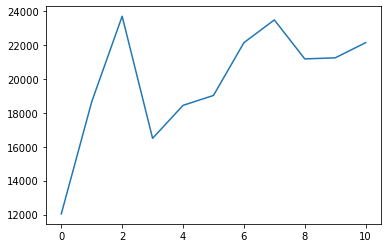

In [150]:
total_cost = []
for i in range(11):
    total_cost.append(get_total_cost(t3[i]))
    
plt.plot(total_cost)

In [152]:
def get_depth(string):
    try:
        return float(string.replace('m', ''))
    except:
        print(sting + ' does not meet the proper format' ) 
        
def get_total_depht(table):
    string = np.array(table['mSSMDm m'].dropna())[-1]
    return get_depth(string)

def get_TVDm(table):
    string = np.array(table['TVDm'].dropna())[-1]
    return get_depth(string)

def get_MudUp(table):
    string = table['mSSMDm m'][table['Formations'] == 'Mud Up'].iloc[0]
    return get_depth(string)

def get_Heel(table):
    try:
        string = table['mSSMDm m'][table['Formations'] == 'Heel'].iloc[0]
        return get_depth(string)
    except:
        return 0.0

get_Heel(t1[0])

838.0

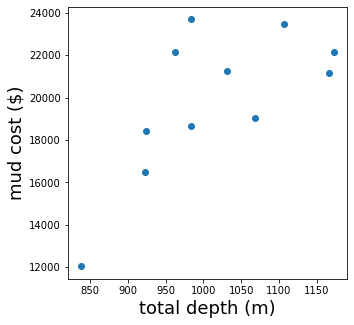

In [153]:
total_depth = []
for i in range(11):
    total_depth.append(get_total_depht(t1[i]))
    
MudUp_depth = []
for i in range(11):
    MudUp_depth.append(get_MudUp(t1[i]))    
    
TVDm_depth = []
for i in range(11):
    TVDm_depth.append(get_TVDm(t1[i]))      
    
Heel_depth = []
for i in range(11):
    Heel_depth.append(get_Heel(t1[i]))     
    
    
fig = plt.figure(figsize = (5,5))    
plt.plot(Heel_depth, total_cost,'o')
plt.xlabel('total depth (m)', fontsize = 18)
plt.ylabel('mud cost ($)', fontsize = 18)
plt.savefig('figure1.png', dpi = 500)
plt.show()

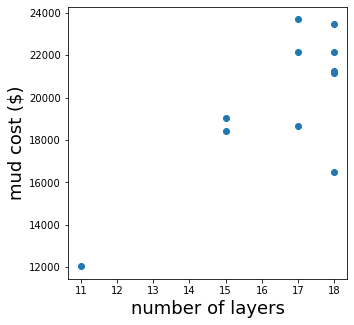

In [59]:
def get_number_of_layers(table):
    return len(table['Formations'].dropna()) -1

total_layers = []
for i in range(11):
    total_layers.append(get_number_of_layers(t1[i]))
    
    
fig = plt.figure(figsize = (5,5))      
plt.plot(total_layers, total_cost,'o')
plt.xlabel('number of layers', fontsize = 18)
plt.ylabel('mud cost ($)', fontsize = 18)
plt.savefig('figure2.png', dpi = 500)
plt.show()

In [170]:
from sklearn.linear_model import LinearRegression

x = pd.DataFrame()
x['Depth'] = total_depth
x['Layers'] = total_layers
x['MudUp'] = MudUp_depth
x['Heel'] = Heel_depth
x['TVDm'] = TVDm_depth
# x.head()

y0 = total_cost

In [171]:
reg = LinearRegression().fit(x, y0)
y0_p = reg.predict(x)

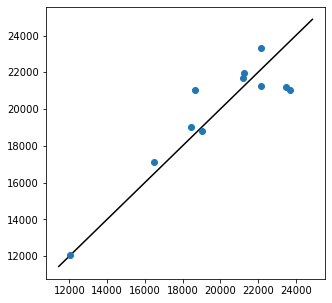

In [195]:
fig = plt.figure(figsize = (5,5))
plt.plot([min(min(y0),min(y0_p))*0.95 , max(max(y0),max(y0_p))*1.05], [min(min(y0),min(y0_p))*0.95, max(max(y0),max(y0_p))*1.05] ,'-', color = 'black')
plt.plot(y0, y0_p, 'o')